In [46]:
import numpy as np
import matplotlib.pyplot as plt
import efficientnet_pytorch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision
import torch
from sklearn.neighbors import NearestNeighbors
import imageio
from PIL import Image

In [47]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [48]:
class NumpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)

In [49]:
@torch.no_grad()
def get_latent_vectors(network, train_loader, device):
    network.eval()
    
    latent_vectors = []
    for cnt, x in enumerate(train_loader):
        x = x.to(device) 
        
        latent_vectors.append(network.extract_features(x).mean(dim=(2,3)))

    latent_vectors = torch.cat(latent_vectors).cpu().numpy()
    return latent_vectors  

In [50]:
def get_data():   
    dataset = np.load('../dr16.npz')['arr_0']
    dataset = NumpyDataset(dataset, transform = transform)

    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)
    
    return dataset, loader

In [51]:
def get_features(loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    network = efficientnet_pytorch.EfficientNet.from_pretrained('efficientnet-b0')

    network.to(device)
    network.eval()

    features = get_latent_vectors(network, loader, device)
    
    return features

In [52]:
def get_query(ra, dec):
    
    url = 'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?ra=' + str(ra) + '&dec=' + str(dec) + '&scale=0.4&height=64&width=64'
    im = imageio.imread(url)
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    print("Query:")
    %matplotlib inline
    plt.imshow(Image.fromarray(im))
    plt.axis('off')
    plt.show()
    plt.close()

    im = transform(Image.fromarray(im))

    network = efficientnet_pytorch.EfficientNet.from_pretrained('efficientnet-b0')
    network.eval()

    with torch.no_grad():
        query_features = network.extract_features(im[None]).mean(dim=(2,3)).cpu().numpy()

    return query_features

In [53]:
def get_nns(query, neigh):
    res = neigh.kneighbors(query)
    similar = res[1][0]
    dists = res[0][0]
    
    return similar, dists

In [58]:
def unnormalize(image):
    image[0] = image[0] * 0.229 + 0.485
    image[1] = image[1] * 0.224 + 0.456
    image[2] = image[2] * 0.225 + 0.406
    return image

def plot(similar, data):
    gridSize = 4
    print("Nearest neighbours:")
    %matplotlib inline

    f, axarr = plt.subplots(gridSize, gridSize,figsize=(15,15)) 

    for layer in range(gridSize):
        for img in range(gridSize):
            objid = similar[layer*gridSize+img]
            axarr[img, layer].imshow(np.moveaxis(unnormalize(data[objid].numpy()), 0, 2))
            axarr[img, layer].axis('off')
            
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()

In [55]:
dataset, loader = get_data()
features = get_features(loader)

neigh = NearestNeighbors(n_neighbors=16)
neigh.fit(features)

(100000, 64, 64, 3)
Loaded pretrained weights for efficientnet-b0


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                 radius=1.0)

Query:


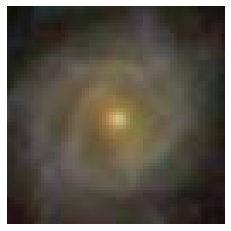

Loaded pretrained weights for efficientnet-b0
Nearest neighbours:


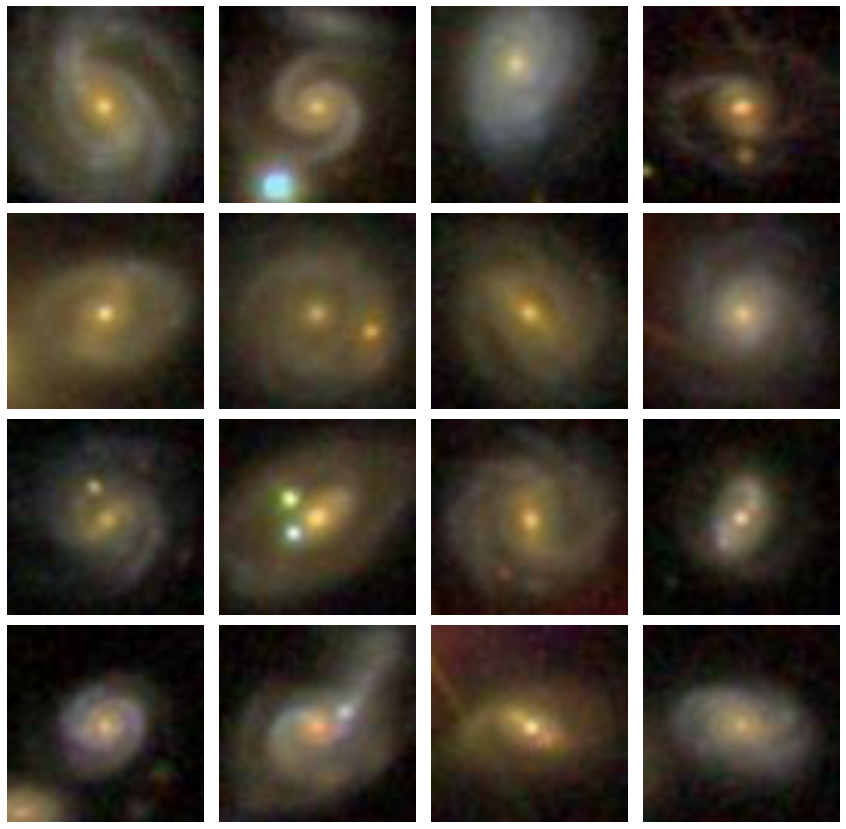

In [59]:
query_features = get_query(   251.529169948, 42.460406009  )
similar, dists = get_nns(query_features, neigh)

plot(similar, dataset)